In [24]:
!pip install -q torchgeo==0.6.0 torch==2.3.1 torchaudio==2.3.1 torchvision==0.18.1 opencv-python

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Getting and preparing Data

In [26]:
import pathlib
from torchgeo.datasets import LandCoverAI

# Define os agnositc root
dataroot = pathlib.Path("data/landcoverai")

# This doesn't apply any transforms
train_dataset = LandCoverAI(root=dataroot)
val_dataset = LandCoverAI(root=dataroot, split="val")
test_dataset = LandCoverAI(root=dataroot, split="test")



In [27]:
import pathlib
from torchgeo.datasets import LandCoverAI

# Define os agnositc root
dataroot = pathlib.Path("data/landcoverai")

# This doesn't apply any transforms
train_dataset = LandCoverAI(root=dataroot)
val_dataset = LandCoverAI(root=dataroot, split="val")
test_dataset = LandCoverAI(root=dataroot, split="test")


In [ ]:
#Sizes
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

In [ ]:
import random
#Let's visualize a few examples
for i in range(3):
    sample = train_dataset[random.randint(0, train_dataset.__len__()- 1)]
    train_dataset.plot(sample)

In [ ]:
for i in range(3):
    sample = val_dataset[random.randint(0, val_dataset.__len__() - 1)]
    train_dataset.plot(sample)

In [31]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor

def compute_mean_std(dataset: Dataset):
    """Compute the mean and standard deviation of a dataset."""
    loader = DataLoader(dataset, batch_size=16, num_workers=0, shuffle=False)
    
    mean = 0.0
    std = 0.0
    n_samples = 0
    
    for data in loader:
        images = data['image']
        batch_samples = images.size(0)  # Batch size (the number of images)
        images = images.view(batch_samples, images.size(1), -1)  # Reshape to (B, C, H*W)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        n_samples += batch_samples

        print(f"Computed for {n_samples} samples out of {len(dataset)}")
    
    mean /= n_samples
    std /= n_samples
    
    return mean, std

# Use the training dataset to compute mean and std
# mean_train, std_train = compute_mean_std(train_dataset)
mean_train = tensor([ 94.2184, 101.2178,  87.5592])
std_train = tensor([25.8982, 22.9285, 18.8788])

# Use the validation dataset to compute mean and std
# mean_val, std_val = compute_mean_std(val_dataset)
mean_val = tensor([ 95.0307, 102.2367,  88.4823])
std_val = tensor([26.2774, 23.1119, 19.1133])

# Use the test dataset to compute mean and std
# mean_test, std_test = compute_mean_std(test_dataset)
mean_test = tensor([ 92.9187, 100.2754,  87.1114])
std_test = tensor([25.5023, 22.6398, 18.5629])

In [ ]:
# Compute overall mean and std with weights corresponding to the number of samples

# Compute the number of samples in each dataset
n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

# Compute the weights
w_train = 1.0 / n_train
w_val = 1.0 / n_val
w_test = 1.0 / n_test

# Compute the mean and std
mean = (w_train * mean_train + w_val * mean_val + w_test * mean_test) / (w_train + w_val + w_test)
std = (w_train * std_train + w_val * std_val + w_test * std_test) / (w_train + w_val + w_test)

# Normalize to [0,1]
MEAN = mean / 255.0
STD = std / 255.0

print(f"Mean: {MEAN}")
print(f"Std: {STD}")


In [ ]:
# Reshape mean and std to match the image dimensions
mean = MEAN.view(3, 1, 1)
std = STD.view(3, 1, 1)
print(f"Mean: {mean}")
print(f"Std: {std}")

In [ ]:
# Explore shape of the dataset
sample = train_dataset[0]
image = sample["image"]
mask = sample["mask"]
print(f"Original Image Shape: {image.shape}")
print(f"Original Mask Shape: {mask.shape}")

# See scale of images
print(f"Max: {image.max()}")
print(f"Min: {image.min()}")

# See scale of masks
print(f"Max: {mask.max()}")
print(f"Min: {mask.min()}")

In [ ]:
# Plot normalized image and mask
for i in range(2):
    sample = train_dataset[random.randint(0, train_dataset.__len__() - 1)]
    print(f"Original Image Shape: {sample['image'].shape} - Max: {sample['image'].max()} - Min: {sample['image'].min()}")

    # Since mean and std are in [0, 1], and image is in [0, 255], we need to scale image to [0, 1]
    scaled_image = sample["image"] / 255.0
    print(f"Scaled Image Shape: {scaled_image.shape} - Max: {scaled_image.max()} - Min: {scaled_image.min()}")

    # Normalize the image
    normalized_image = (scaled_image - mean) / std
    
    train_dataset.plot(sample)
    train_dataset.plot({
        "image": normalized_image,
        "mask": sample["mask"]
    })

# We can see how it helps makes differences 'stand out'

Class Background: 57.93%
Class Building: 0.86%
Class Woodland: 33.13%
Class Water: 6.46%
Class Road: 1.62%


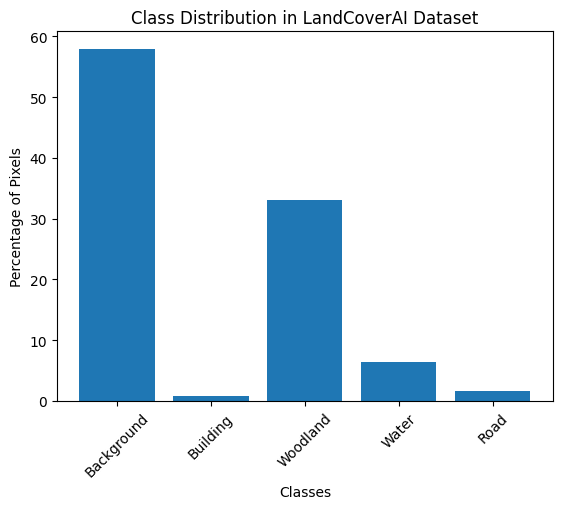

In [36]:
import torch
from collections import defaultdict
import matplotlib.pyplot as plt

# Class names for visualization (assuming you have 5 classes)
class_names = ["Background", "Building", "Woodland", "Water", "Road"]

# Initialize a dictionary to count pixels per class
class_counts = defaultdict(int)

# Iterate through the entire dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    mask = sample['mask']  # Assuming the mask is a key in the sample dictionary
    
    # Count pixels for each class in the mask
    for class_label in range(len(class_names)):
        class_counts[class_label] += torch.sum(mask == class_label).item()

# Total number of pixels
total_pixels = sum(class_counts.values())

# Calculate the distribution as a percentage
class_distribution = {class_names[k]: (v / total_pixels) * 100 for k, v in class_counts.items()}

# Display the distribution
for class_name, percentage in class_distribution.items():
    print(f"Class {class_name}: {percentage:.2f}%")

# Optional: Visualize the distribution as a bar chart
plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Classes')
plt.ylabel('Percentage of Pixels')
plt.title('Class Distribution in LandCoverAI Dataset')
plt.xticks(rotation=45)
plt.show()

In [37]:
no_road_images = 0
no_building_images = 0
no_water_images = 0

# Loop through the dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    mask = sample['mask']
    
    # Check if any road, building, or water pixels exist
    if torch.sum(mask == 1) == 0:
        no_building_images += 1
    if torch.sum(mask == 2) == 0:
        no_water_images += 1
    if torch.sum(mask == 4) == 0:
        no_road_images += 1

# Calculate the percentage of images for each class
total_images = len(train_dataset)
no_road_percentage = (no_road_images / total_images) * 100
no_building_percentage = (no_building_images / total_images) * 100
no_water_percentage = (no_water_images / total_images) * 100

# Display the results
print(f"Percentage of images with no roads: {no_road_percentage:.2f}%")
print(f"Percentage of images with no buildings: {no_building_percentage:.2f}%")
print(f"Percentage of images with no water: {no_water_percentage:.2f}%")

Percentage of images with no roads: 62.70%
Percentage of images with no buildings: 83.99%
Percentage of images with no water: 26.24%


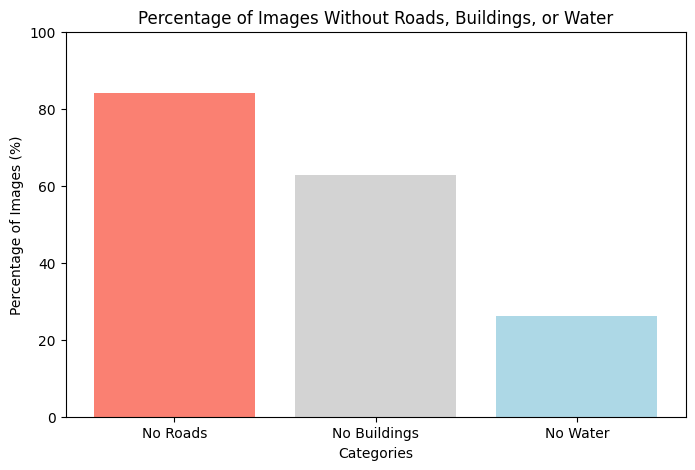

In [40]:
categories = ['No Roads', 'No Buildings', 'No Water']
percentages = [no_building_percentage, no_road_percentage, no_water_percentage]

# Plotting the percentages
plt.figure(figsize=(8, 5))
plt.bar(categories, percentages, color=['salmon', 'lightgrey', 'lightblue'])
plt.xlabel('Categories')
plt.ylabel('Percentage of Images (%)')
plt.title('Percentage of Images Without Roads, Buildings, or Water')
plt.ylim(0, 100)

# Show plot
plt.show()